[![GitHub](https://img.shields.io/badge/Github-hibana2077-blue?style=plastic-square&logo=github)](https://github.com/hibana2077)
[![Colab](https://img.shields.io/badge/Colab-Open%20in%20Colab-blue?style=plastic-square&logo=googlecolab)](https://colab.research.google.com/github/hibana2077/hibana2077/blob/master/train/train.ipynb)

如果要訓練這份資料集會需要安裝talib套件，請參考[這裡](https://www.lfd.uci.edu/~gohlke/pythonlibs/#ta-lib)下載對應的版本，並使用pip安裝。

In [1]:
# !pip install ccxt

In [2]:
# !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
# !tar -xzvf ta-lib-0.4.0-src.tar.gz
# %cd ta-lib
# !./configure --prefix=/usr
# !make
# !make install
# !pip install Ta-Lib

In [1]:
from ccxt import binance
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch import optim
from torch.nn import functional as F
from talib import abstract
import pandas as pd
import numpy as np
import torch
import os
import sys

# 環境整理

In [2]:
ls_dir = os.listdir(path="..")
if "data" not in ls_dir:
    os.mkdir(path="../data")
if "model" not in ls_dir:
    os.mkdir(path="../model")
if "data" in ls_dir:
    ls_dir = os.listdir(path="../data")
    #remove all files in data folder
    for file in ls_dir:os.remove(path="../data/"+file)

# 下載資料集

In [3]:
# Download data

binance = binance()
symbol = 'ETH/USDT'
timeframe = '15m'
file_name = f"../data/{symbol.replace('/', '_')}_{timeframe}.csv"
start = binance.parse8601('2022-01-01T00:00:00Z')
end = binance.parse8601('2023-01-01T00:00:00Z')
cnt_time = start
data = []
while cnt_time < end:
    ohlcv = binance.fetch_ohlcv(symbol, timeframe, cnt_time)
    data += ohlcv
    cnt_time = ohlcv[-1][0] + 900000 
df = pd.DataFrame(data, columns=['time', 'open', 'high', 'low', 'close', 'volume'])
df['time'] = pd.to_datetime(df['time'], unit='ms')
df.to_csv(file_name, index=False)

# 讀取資料集

In [2]:
#如果有下载好的數據，可以直接讀取
data_file = '../data/ETH_USDT_15m.csv' #-> 可以自行更換
df = pd.read_csv(data_file)

# 數據處理

- 計算RSI
- 計算MACD
- 計算OBV
- 計算CCI
- 改成變化百分比 -> 標準化

關於技術指標的說明可以參考[這裡](https://www.investopedia.com/terms/t/technicalindicator.asp)，或是google。

In [4]:
df['RSI'] = abstract.RSI(df, timeperiod=14)
df['MACD'] = abstract.MACD(df, fastperiod=12, slowperiod=26, signalperiod=9)['macd'] #只取MACD
df['OBV'] = abstract.OBV(df, timeperiod=14)
df['CCI'] = abstract.CCI(df, timeperiod=14)
df['ATR'] = abstract.ATR(df, timeperiod=14)
df['ADX'] = abstract.ADX(df, timeperiod=14)
df['MFI'] = abstract.MFI(df, timeperiod=14)
df['CLOSE_percent'] = df['close'].pct_change()
#由於RSI MACD OBV CCI 他們已經是標準化的，所以不需要再標準化

# 設定買賣點

將買賣點分為下跌、上漲、不動，並將數據轉成one-hot編碼。

In [5]:
df['UP'] = df['CLOSE_percent'].apply(lambda x: 1 if x > 0 else 0)
df['DOWN'] = df['CLOSE_percent'].apply(lambda x: 1 if x < 0 else 0)
df['UP'] = df['UP'].shift(-1) #shift UP DOWN 一個單位，因為我們要預測的是下一個時間點的漲跌
df['DOWN'] = df['DOWN'].shift(-1)

df = df.dropna()


In [3]:
df

,time,open,high,low,close,volume,RSI,MACD,OBV,CCI,ATR,ADX,MFI,UP,DOWN
0,2022-01-01 08:15:00,0.946260,0.941543,0.947608,0.947727,0.002398,0.534568,0.533569,0.888414,0.484903,0.205796,0.264040,0.507308,1.0,0.0
1,2022-01-01 08:30:00,0.947858,0.941063,0.947614,0.947993,0.002854,0.539149,0.536218,0.888673,0.477682,0.199213,0.258053,0.523490,0.0,1.0
2,2022-01-01 08:45:00,0.947989,0.944291,0.949045,0.947704,0.003717,0.532898,0.537880,0.888362,0.515845,0.198994,0.261002,0.447707,1.0,0.0
3,2022-01-01 09:00:00,0.947617,0.943009,0.947648,0.950474,0.004672,0.582682,0.544218,0.888731,0.538501,0.199162,0.257649,0.416577,0.0,1.0
4,2022-01-01 09:15:00,0.950474,0.942986,0.949239,0.948076,0.003983,0.529185,0.544908,0.888403,0.543989,0.194037,0.254536,0.411309,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35461,2023-01-05 17:30:00,0.117445,0.114930,0.122333,0.117112,0.003971,0.418599,0.539354,0.310202,0.447685,0.026181,0.249130,0.448492,0.0,1.0
35462,2023-01-05 17:45:00,0.117109,0.114453,0.122176,0.117042,0.002877,0.412897,0.538768,0.309941,0.414423,0.024402,0.253226,0.399756,1.0,0.0
35463,2023-01-05 18:00:00,0.117042,0.114643,0.122079,0.117156,0.005562,0.425684,0.538585,0.310363,0.412165,0.023690,0.250799,0.579382,1.0,0.0
35464,2023-01-05 18:15:00,0.117156,0.115538,0.122400,0.118251,0.015938,0.532847,0.540475,0.311407,0.564113,0.024910,0.227466,0.557552,0.0,1.0


In [7]:
#正規化
df['RSI'] = (df['RSI'] - df['RSI'].min()) / (df['RSI'].max() - df['RSI'].min())
df['MACD'] = (df['MACD'] - df['MACD'].min()) / (df['MACD'].max() - df['MACD'].min())
df['OBV'] = (df['OBV'] - df['OBV'].min()) / (df['OBV'].max() - df['OBV'].min())
df['CCI'] = (df['CCI'] - df['CCI'].min()) / (df['CCI'].max() - df['CCI'].min())
df['ATR'] = (df['ATR'] - df['ATR'].min()) / (df['ATR'].max() - df['ATR'].min())
df['ADX'] = (df['ADX'] - df['ADX'].min()) / (df['ADX'].max() - df['ADX'].min())
df['MFI'] = (df['MFI'] - df['MFI'].min()) / (df['MFI'].max() - df['MFI'].min())
df['open'] = (df['open'] - df['open'].min()) / (df['open'].max() - df['open'].min())
df['high'] = (df['high'] - df['high'].min()) / (df['high'].max() - df['high'].min())
df['low'] = (df['low'] - df['low'].min()) / (df['low'].max() - df['low'].min())
df['close'] = (df['close'] - df['close'].min()) / (df['close'].max() - df['close'].min())
df['volume'] = (df['volume'] - df['volume'].min()) / (df['volume'].max() - df['volume'].min())

C:\Users\李軒豪\AppData\Local\Temp\ipykernel_36616\1144569331.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RSI'] = (df['RSI'] - df['RSI'].min()) / (df['RSI'].max() - df['RSI'].min())
C:\Users\李軒豪\AppData\Local\Temp\ipykernel_36616\1144569331.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['MACD'] = (df['MACD'] - df['MACD'].min()) / (df['MACD'].max() - df['MACD'].min())
C:\Users\李軒豪\AppData\Local\Temp\ipykernel_36616\1144569331.py:4: SettingWithCopyWarning: 
A value is trying to be set on a co

In [8]:
df.drop(['CLOSE_percent'], axis=1, inplace=True)

C:\Users\李軒豪\AppData\Roaming\Python\Python310\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [4]:
df

,time,open,high,low,close,volume,RSI,MACD,OBV,CCI,ATR,ADX,MFI,UP,DOWN
0,2022-01-01 08:15:00,0.946260,0.941543,0.947608,0.947727,0.002398,0.534568,0.533569,0.888414,0.484903,0.205796,0.264040,0.507308,1.0,0.0
1,2022-01-01 08:30:00,0.947858,0.941063,0.947614,0.947993,0.002854,0.539149,0.536218,0.888673,0.477682,0.199213,0.258053,0.523490,0.0,1.0
2,2022-01-01 08:45:00,0.947989,0.944291,0.949045,0.947704,0.003717,0.532898,0.537880,0.888362,0.515845,0.198994,0.261002,0.447707,1.0,0.0
3,2022-01-01 09:00:00,0.947617,0.943009,0.947648,0.950474,0.004672,0.582682,0.544218,0.888731,0.538501,0.199162,0.257649,0.416577,0.0,1.0
4,2022-01-01 09:15:00,0.950474,0.942986,0.949239,0.948076,0.003983,0.529185,0.544908,0.888403,0.543989,0.194037,0.254536,0.411309,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35461,2023-01-05 17:30:00,0.117445,0.114930,0.122333,0.117112,0.003971,0.418599,0.539354,0.310202,0.447685,0.026181,0.249130,0.448492,0.0,1.0
35462,2023-01-05 17:45:00,0.117109,0.114453,0.122176,0.117042,0.002877,0.412897,0.538768,0.309941,0.414423,0.024402,0.253226,0.399756,1.0,0.0
35463,2023-01-05 18:00:00,0.117042,0.114643,0.122079,0.117156,0.005562,0.425684,0.538585,0.310363,0.412165,0.023690,0.250799,0.579382,1.0,0.0
35464,2023-01-05 18:15:00,0.117156,0.115538,0.122400,0.118251,0.015938,0.532847,0.540475,0.311407,0.564113,0.024910,0.227466,0.557552,0.0,1.0


In [5]:
df['UP'].value_counts()

1.0    17743
0.0    17723
Name: UP, dtype: int64

In [6]:
df['DOWN'].value_counts()

0.0    17775
1.0    17691
Name: DOWN, dtype: int64

看起來數據蠻平衡的

# 儲存資料

In [12]:
df.to_csv(file_name, index=False)

# 分割成X、y

In [7]:

X,y = list(),list()
ref_bar = 10

for i in range(len(df)-ref_bar):
    #df.iloc.values 會回傳一個numpy array
    X.append(df.iloc[i:i+ref_bar, 1:13].values) # i to i+ref_bar-1
    y.append(df.iloc[i+ref_bar-1, 13:].values) # i+ref_bar-1



In [8]:
X[0]#這裡會出現10個array，每個array裡面有12個數字，分別是open high low close volume RSI MACD OBV CCI ATR ADX MFI

array([[0.9462601 , 0.94154346, 0.94760773, 0.94772732, 0.00239768,
        0.53456777, 0.53356898, 0.88841379, 0.48490306, 0.20579619,
        0.26403984, 0.50730778],
       [0.94785826, 0.94106278, 0.94761441, 0.94799256, 0.00285434,
        0.53914929, 0.53621835, 0.88867347, 0.47768198, 0.19921307,
        0.25805317, 0.52348981],
       [0.9479892 , 0.94429071, 0.94904533, 0.94770382, 0.00371728,
        0.53289784, 0.53788012, 0.88836207, 0.51584476, 0.19899366,
        0.26100219, 0.44770718],
       [0.94761652, 0.94300888, 0.94764785, 0.95047374, 0.00467237,
        0.58268216, 0.54421754, 0.88873072, 0.53850137, 0.19916168,
        0.25764913, 0.41657723],
       [0.95047374, 0.94298552, 0.94923924, 0.9480765 , 0.00398304,
        0.52918494, 0.54490801, 0.88840338, 0.54398878, 0.19403652,
        0.25453556, 0.41130869],
       [0.94807985, 0.94197741, 0.94541455, 0.94520249, 0.00313282,
        0.47190317, 0.54031401, 0.88812701, 0.4687601 , 0.19848396,
        0.23569366,

In [9]:
y[0]

array([0.0, 1.0], dtype=object)

In [10]:
X = np.array(X)
X = torch.tensor(X, dtype=torch.float32)

In [11]:
y = np.array(y,dtype=np.float32)
y = torch.tensor(y, dtype=torch.float32)

In [12]:
y

tensor([[0., 1.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [0., 1.]])

In [13]:
print(f"X shape: {X.shape} , y shape: {y.shape}")

X shape: torch.Size([35456, 10, 12]) , y shape: torch.Size([35456, 2])


In [14]:
X[0]

tensor([[0.9463, 0.9415, 0.9476, 0.9477, 0.0024, 0.5346, 0.5336, 0.8884, 0.4849,
         0.2058, 0.2640, 0.5073],
        [0.9479, 0.9411, 0.9476, 0.9480, 0.0029, 0.5391, 0.5362, 0.8887, 0.4777,
         0.1992, 0.2581, 0.5235],
        [0.9480, 0.9443, 0.9490, 0.9477, 0.0037, 0.5329, 0.5379, 0.8884, 0.5158,
         0.1990, 0.2610, 0.4477],
        [0.9476, 0.9430, 0.9476, 0.9505, 0.0047, 0.5827, 0.5442, 0.8887, 0.5385,
         0.1992, 0.2576, 0.4166],
        [0.9505, 0.9430, 0.9492, 0.9481, 0.0040, 0.5292, 0.5449, 0.8884, 0.5440,
         0.1940, 0.2545, 0.4113],
        [0.9481, 0.9420, 0.9454, 0.9452, 0.0031, 0.4719, 0.5403, 0.8881, 0.4688,
         0.1985, 0.2357, 0.3333],
        [0.9452, 0.9397, 0.9459, 0.9468, 0.0021, 0.5031, 0.5396, 0.8883, 0.4764,
         0.1936, 0.2182, 0.3379],
        [0.9468, 0.9436, 0.9483, 0.9471, 0.0047, 0.5096, 0.5397, 0.8887, 0.5852,
         0.1941, 0.2144, 0.4092],
        [0.9471, 0.9396, 0.9383, 0.9376, 0.0132, 0.3532, 0.5228, 0.8878, 0.2761,

In [15]:
y[0]

tensor([0., 1.])

# 建立資料集類別

- 要繼承torch.utils.data.Dataset
- 要實作`__len__`、`__getitem__`
- 後面要用DataLoader取用

In [16]:
#用sklearn來分成train val test
# train:val:test = 6:3:1
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.75, random_state=42)

In [17]:
print(f"X_train shape: {X_train.shape} , y_train shape: {y_train.shape}")

X_train shape: torch.Size([21273, 10, 12]) , y_train shape: torch.Size([21273, 2])


In [18]:
print(f"X_test shape: {X_test.shape} , y_test shape: {y_test.shape}")

X_test shape: torch.Size([10638, 10, 12]) , y_test shape: torch.Size([10638, 2])


In [19]:
print(f"X_val shape: {X_val.shape} , y_val shape: {y_val.shape}")

X_val shape: torch.Size([3545, 10, 12]) , y_val shape: torch.Size([3545, 2])


In [20]:
class TrainDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [21]:
class ValDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [22]:
class TestDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [23]:
train_dataset = TrainDataset(X_train, y_train)
val_dataset = ValDataset(X_val, y_val)
test_dataset = TestDataset(X_test, y_test)

# 建立模型

- 要繼承torch.nn.Module
- 可能要多建立不同的模型，到時候看結果再調整 -> 先讓數據流得通，再去看成績做調整。

- ver1 -> CNN+MLP
- ver2 -> CNN+LSTM+MLP
- ver3 -> CNN+GRU+MLP
- ver4 -> CNN+LSTM+GRU+MLP
- ver5 -> CNN+GRU+MLP+Dropout

In [24]:
class SelectItem(torch.nn.Module):#這是用來取出多個輸出其中一個的輸出，如果不用sequential的話，就可以不用這個
    def __init__(self, item_index):
        super(SelectItem, self).__init__()
        self._name = 'selectitem'
        self.item_index = item_index

    def forward(self, inputs):
        return inputs[self.item_index]

In [25]:
class CCV1(nn.Module):#CNN+MLP in (64,10,12) out (64,2)
    def __init__(self):
        super(CCV1, self).__init__()
        self.conv1 = nn.Conv1d(10, 64, kernel_size=3, stride=1, padding=1)
        self.Linear1 = nn.Linear(768, 128)
        self.Linear2 = nn.Linear(128, 256)
        self.Linear3 = nn.Linear(256, 1024)
        self.Linear4 = nn.Linear(1024, 256)
        self.Linear5 = nn.Linear(256, 128)
        self.Linear6 = nn.Linear(128, 64)
        self.Linear7 = nn.Linear(64, 2)
        self.Dropout1 = nn.Dropout(0.2)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(-1, 64*12)
        x = F.relu(self.Linear1(x))
        x = F.relu(self.Linear2(x))
        x = F.relu(self.Linear3(x))
        x = self.Dropout1(x)
        x = F.relu(self.Linear4(x))
        x = F.relu(self.Linear5(x))
        x = F.relu(self.Linear6(x))
        x = self.Linear7(x)
        return x

In [26]:
class CCV2(nn.Module):#CNN+MLP+LSTM in (64,10,12) out (64,2)
    def __init__(self):
        super(CCV2, self).__init__()
        self.conv1 = nn.Conv1d(10, 64, kernel_size=3, stride=1, padding=1)
        self.Linear1 = nn.Linear(768, 1024)
        self.Linear2 = nn.Linear(1024, 2048)
        self.Linear3 = nn.Linear(2048, 1024)
        self.Linear4 = nn.Linear(1024, 512)
        self.Linear5 = nn.Linear(512, 256)
        self.Linear6 = nn.Linear(256, 128)
        self.Linear7 = nn.Linear(128, 64)
        self.Linear8 = nn.Linear(64, 2)
        self.Dropout1 = nn.Dropout(0.2)
        self.LSTM1 = nn.LSTM(2048,2048,20)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(-1, 64*12)
        x = F.relu(self.Linear1(x))
        x = F.relu(self.Linear2(x))
        x = self.Dropout1(x)
        x = F.relu(SelectItem(0)(self.LSTM1(x)))
        x = F.relu(self.Linear3(x))
        x = F.relu(self.Linear4(x))
        x = F.relu(self.Linear5(x))
        x = F.relu(self.Linear6(x))
        x = F.relu(self.Linear7(x))
        x = self.Linear8(x)
        return x


In [27]:
class CCV3(nn.Module):#CNN+MLP+LSTM in (64,10,12) out (64,2)
    def __init__(self):
        super(CCV3, self).__init__()
        self.conv1 = nn.Conv1d(10, 64, kernel_size=3, stride=1, padding=1)
        self.Linear1 = nn.Linear(768, 1024)
        self.Linear2 = nn.Linear(1024, 512)
        self.Linear3 = nn.Linear(512, 256)
        self.Linear4 = nn.Linear(256, 128)
        self.Linear5 = nn.Linear(128, 64)
        self.Linear6 = nn.Linear(64, 2)
        self.Dropout1 = nn.Dropout(0.2)
        self.LSTM1 = nn.LSTM(512,512,2)
        self.LSTM2 = nn.LSTM(256,256,2)
        self.LSTM3 = nn.LSTM(128,128,2)
        self.LSTM4 = nn.LSTM(64,64,2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = x.view(-1, 64*12)
        x = F.relu(self.Linear1(x))
        x = F.relu(self.Linear2(x))
        x = self.Dropout1(x)
        x = F.relu(SelectItem(0)(self.LSTM1(x)))
        x = self.Dropout1(x)
        x = F.relu(self.Linear3(x))
        x = F.relu(SelectItem(0)(self.LSTM2(x)))
        x = self.Dropout1(x)
        x = F.relu(self.Linear4(x))
        x = F.relu(SelectItem(0)(self.LSTM3(x)))
        x = self.Dropout1(x)
        x = F.relu(self.Linear5(x))
        x = F.relu(SelectItem(0)(self.LSTM4(x)))
        x = self.Linear6(x)
        return x

## Note

1) model
    - `__init__`: define [layers](https://pytorch.org/docs/stable/nn.html)
    - forward: forward pass -> compute prediction
2) loss and optimizer
    - lr: learning rate [default=0.001]
    - momentum: momentum for optimizer [default=0.9]
    - criterion: loss function [in torch.nn] eg.nn.BCELoss()
    - optimizer: optimizer [in torch.optim] eg.torch.optim.SGD()
        - eg. optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
3) training loop
    - forward pass: compute prediction and loss

        ```python
        output = model(data)
        loss = criterion(output, target)
        ```
        
    - backward pass: loss.backward()
    - update weights: optimizer.step()
    - zero the gradients: optimizer.zero_grad()

# TODO

- 寫訓練方法
    - using dataloader
        - batch and epoch
- 寫驗證方法
    - using model.eval()


In [28]:
def train(model, train_loader, optimizer, criterion, epoch, device):
    if epoch == 0: print("Training...")
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx == 0:
            print(f"data shape: {data.shape} , target shape: {target.shape} , output shape: {output.shape}")
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [29]:
def test(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.argmax(1, keepdim=True).view_as(pred)).sum().item() #

    test_loss /= len(test_loader.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return (100. * correct / len(test_loader.dataset)), test_loss

In [30]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
EPOCHS = 10
print("=== Info ===")
print(f"Device : {DEVICE}")
print(f"Epochs : {EPOCHS}")
print("============")

=== Info ===
Device : cpu
Epochs : 10


In [28]:
model = CCV1().to(DEVICE)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
criterion = F.cross_entropy

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

test_acc_list = []
test_loss_list = []

for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer, criterion, epoch, DEVICE)
    test_acc, test_loss = test(model, test_loader, criterion, DEVICE)
    test_acc_list.append(test_acc)
    test_loss_list.append(test_loss)

data shape: torch.Size([64, 10, 12]) , target shape: torch.Size([64, 2]) , output shape: torch.Size([64, 2])
Train Epoch: 1 [0/21273 (0%)]	Loss: 0.703216
Train Epoch: 1 [6400/21273 (30%)]	Loss: 0.682133
Train Epoch: 1 [12800/21273 (60%)]	Loss: 0.691561
Train Epoch: 1 [19200/21273 (90%)]	Loss: 0.692904
Test set: Average loss: 0.0109, Accuracy: 5296/10638 (50%)
data shape: torch.Size([64, 10, 12]) , target shape: torch.Size([64, 2]) , output shape: torch.Size([64, 2])
Train Epoch: 2 [0/21273 (0%)]	Loss: 0.692697
Train Epoch: 2 [6400/21273 (30%)]	Loss: 0.693524
Train Epoch: 2 [12800/21273 (60%)]	Loss: 0.692126
Train Epoch: 2 [19200/21273 (90%)]	Loss: 0.692862
Test set: Average loss: 0.0109, Accuracy: 5296/10638 (50%)
data shape: torch.Size([64, 10, 12]) , target shape: torch.Size([64, 2]) , output shape: torch.Size([64, 2])
Train Epoch: 3 [0/21273 (0%)]	Loss: 0.690884
Train Epoch: 3 [6400/21273 (30%)]	Loss: 0.694270
Train Epoch: 3 [12800/21273 (60%)]	Loss: 0.695901
Train Epoch: 3 [19200/2

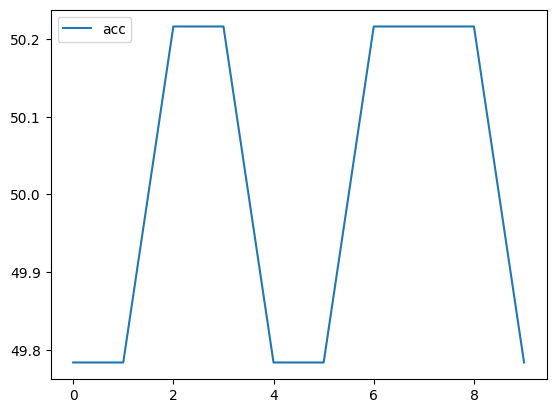

In [29]:
#plot acc
from matplotlib import pyplot as plt
plt.plot(test_acc_list,label='acc')
plt.legend()
plt.show()

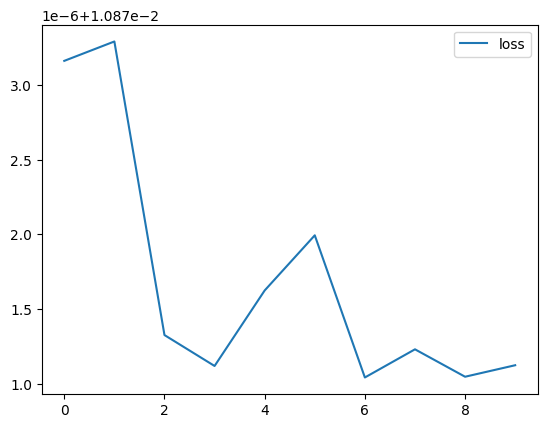

In [30]:
#plot loss
plt.plot(test_loss_list,label='loss')
plt.legend()
plt.show()

In [47]:
print(model(X_val[0].to(DEVICE)))
print(y_val[0])

tensor([[0.0058, 0.0332]], grad_fn=<AddmmBackward0>)
tensor([1., 0.])


In [32]:
model3 = CCV3().to(DEVICE)
optimizer = optim.SGD(model3.parameters(), lr=0.01, momentum=0.5)
criterion = F.cross_entropy

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

test_acc_list = []
test_loss_list = []

for epoch in range(1, EPOCHS + 1):
    train(model3, train_loader, optimizer, criterion, epoch, DEVICE)
    test_acc, test_loss = test(model3, test_loader, criterion, DEVICE)
    test_acc_list.append(test_acc)
    test_loss_list.append(test_loss)

data shape: torch.Size([64, 10, 12]) , target shape: torch.Size([64, 2]) , output shape: torch.Size([64, 2])
Train Epoch: 1 [0/21273 (0%)]	Loss: 0.681689
Train Epoch: 1 [6400/21273 (30%)]	Loss: 0.687777
Train Epoch: 1 [12800/21273 (60%)]	Loss: 0.694113
Train Epoch: 1 [19200/21273 (90%)]	Loss: 0.692692
Test set: Average loss: 0.0109, Accuracy: 5296/10638 (50%)
data shape: torch.Size([64, 10, 12]) , target shape: torch.Size([64, 2]) , output shape: torch.Size([64, 2])
Train Epoch: 2 [0/21273 (0%)]	Loss: 0.692207
Train Epoch: 2 [6400/21273 (30%)]	Loss: 0.693185
Train Epoch: 2 [12800/21273 (60%)]	Loss: 0.692991
Train Epoch: 2 [19200/21273 (90%)]	Loss: 0.694084
Test set: Average loss: 0.0109, Accuracy: 5296/10638 (50%)
data shape: torch.Size([64, 10, 12]) , target shape: torch.Size([64, 2]) , output shape: torch.Size([64, 2])
Train Epoch: 3 [0/21273 (0%)]	Loss: 0.694058
Train Epoch: 3 [6400/21273 (30%)]	Loss: 0.689755
Train Epoch: 3 [12800/21273 (60%)]	Loss: 0.693026
Train Epoch: 3 [19200/2

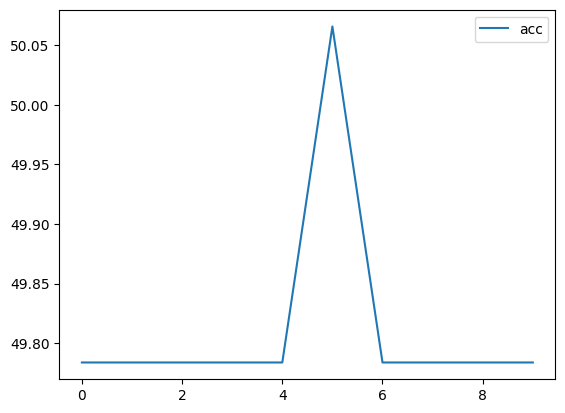

In [33]:
#plot acc
from matplotlib import pyplot as plt
plt.plot(test_acc_list,label='acc')
plt.legend()
plt.show()

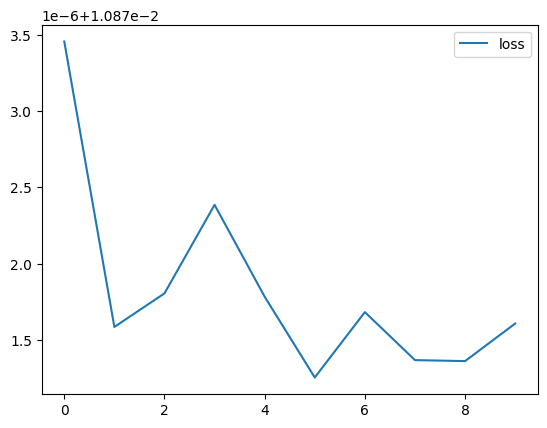

In [34]:
#plot loss
plt.plot(test_loss_list,label='loss')
plt.legend()
plt.show()

In [ ]:
#confusion matrix
#把模型的輸出轉成one-hot
#TT TF
#FT FF